# Linear Econometric Models

So far in our Scientific Python adventures we have covered:

* NumPy
* Pandas
* Matplotlib

For our next adventure into Python's Scientific stack we are going to look into estimating simple linear econometric models. This is just the tip of the iceberg as far as statistical modelling packages and capabilities in Python - but it is enough to get you hopefully confident enough to go looking for further modelling libraries on your own.

This notebook is structured a little bit like how a simple project might look. We do all the tasks needed from downloading the data, some data visualization and the econometrics together. This should show you how far we have come on our Python Adventure. 

## Loading some data

The plan is to use the data from Acemoglu, Johnson and Robinson's 2001 AER paper (hereafter AJR) on linking institutions to economic development as an example on how to run OLS and IV style regression models. That means we have to load the data.


### Importing into Pandas

AJR provide multiple datasets on their replication page that we have put the 'data' directory. 
Each dataset allows us to construct estimates from one of the tables in the paper.

We'll start by working with table 1's data, `maketable1.dta`. 
It's a Stata datafile, so we will need to use the function `read_stata` from the pandas library:

In [1]:
import pandas as pd


In [2]:
data = pd.read_stata('data/maketable1.dta')

In [3]:
data.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Visualization

AJR's main hypothesis is to investigate the relationship between institutional differences and economic outcomes.

To do this the paper operationalizes the variables of interest as follows:

* economic outcomes are proxied by log GDP per capita in 1995, adjusted for exchange rates, `logpgp95`
* institutional differences are proxied by an index of protection against expropriation on average over 1985-95, constructed by the Political Risk Services Group, `avexpr`

Before we jump on to running regressions, let's check out whether there is any relationship between these variables graphically:

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

Text(0, 0.5, 'Income')

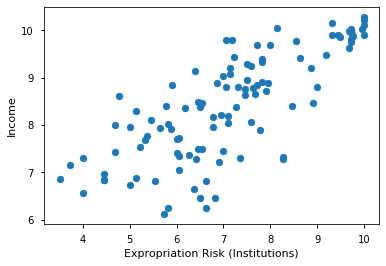

In [7]:
fig, ax = plt.subplots()

ax.scatter(data['avexpr'], data['logpgp95'])
ax.set_xlabel('Expropriation Risk (Institutions)')
ax.set_ylabel('Income')

So there definitely appears to be a positive correlation between instututions and income. 

## Univariate Regression

OK, so now we have visualized data let's run some OLS regressions. We will start with the simplest regression we can think of to map:

$$
logpgp95_i = \beta_0 + \beta_1 avexpr + u_i
$$


To run OLS regressions we'll need a new package, `statsmodels`.

First we need to load the `statsmodels` package:

In [10]:
import statsmodels as sm
sm.__version__

'0.12.0'

There's two ways to write out the specification for a regression, the easiest is by writing a formulaic description of the regression we want to estimate:

In [11]:
import statsmodels.formula.api as smf

In [12]:
simple_reg = smf.ols('logpgp95 ~ avexpr', data=data)

To estimate the regression specification, we use the `fit` method:

In [13]:
results = simple_reg.fit()

The `results` object now contains a bunch of information.
Most of the 'standard output' we have come to expect from software like STATA are contained in the `.summary()`:

In [14]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Mon, 13 Sep 2021   Prob (F-statistic):           4.16e-24
Time:                        12:08:11   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6261      0.301     15.391      0.0

An observation was mistakenly dropped from the results in the original paper (see the note located in maketable2.do from Acemoglu’s webpage), so our coefficients differ slightly from the ones in the original paper.

We can get the predicted values from the regression using the `.predict()` attribute. Let's use these in a plot that has predicted versus actual values.
To do this, we'll need to drop missing data from our observations because the `predict()` method doesn't do well with missing data:

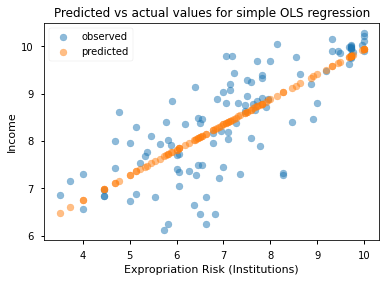

In [18]:
# Drop missing observations from whole sample

df_plot = data.dropna(subset=['logpgp95', 'avexpr'])

# Plot predicted values

fig, ax = plt.subplots()

ax.scatter(df_plot['avexpr'], df_plot['logpgp95'], alpha=0.5, label='observed')
ax.scatter(df_plot['avexpr'], results.predict(), alpha=0.5, label='predicted')
ax.set_xlabel('Expropriation Risk (Institutions)')
ax.set_ylabel('Income')
ax.set_title('Predicted vs actual values for simple OLS regression')
ax.legend()

We mentioned that there is two ways to call a linear regression, and so far we showed how to use the formula interface which is probably the recommended way to do this in most applications.

If we end up in a situation where we have to run a regression many times the formula interface actually slows down the code because python has to deconstruct it to get the exact information it needs. Examples where this may occur (and I have come across) are if a regression is part of a nested loop over structural parameters (BLP estimation for IO people), or if we are coding up our own indirect inference procedure.

Here's another way to get the same result that is usually faster, although we have to import some additional functionality:

In [21]:
from statsmodels.tools.tools import add_constant

data = add_constant(data, has_constant='add')

In [22]:
data.columns

Index(['const', 'shortnam', 'euro1900', 'excolony', 'avexpr', 'logpgp95',
       'cons1', 'cons90', 'democ00a', 'cons00a', 'extmort4', 'logem4',
       'loghjypl', 'baseco'],
      dtype='object')

In [23]:
from statsmodels.regression.linear_model import OLS

In [24]:
simple_reg2 = OLS(endog=data['logpgp95'], 
                     exog=data[['const', 'avexpr']], 
                     missing='drop')
type(simple_reg2)

statsmodels.regression.linear_model.OLS

In [25]:
print(simple_reg2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Thu, 17 Aug 2017   Prob (F-statistic):           4.16e-24
Time:                        16:32:59   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

Notice that this gives us exactly the same results.

## Multivariate Regression

Univariate regression is rarely enough in social science. At a bare minimum we are worried about other factors affecting GDP that are not included in our model that are also correlated with institutional quality. As reasonably good econometricians we know that this causes bias / inconsistency in our estimates for $\hat{\beta}$.

So let's add more regressors! AJR argue that climate influences economic outcomes, and it is probably correlated to institutional quality (Discuss / think about why). They operationalize this by including latitude as a proxy. 

Notice that our current data, `data`, doesn't have that variable due to the 'interesting' way Acemoglu structures his data and do files on the web. We'll need the data `maketable2.dta`:

In [19]:
# import new data by overwriting the old one
data = pd.read_stata('data/maketable2.dta')

Now, using the formula interface we can readily add this variable:

In [20]:
reg2 = smf.ols('logpgp95 ~ avexpr + lat_abst', data=data)
results2 = reg2.fit() 

In [21]:
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     89.05
Date:                Mon, 13 Sep 2021   Prob (F-statistic):           1.42e-23
Time:                        12:11:26   Log-Likelihood:                -118.09
No. Observations:                 111   AIC:                             242.2
Df Residuals:                     108   BIC:                             250.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8729      0.328     14.855      0.0

This is nice - but its a little hard to compare coefficients and the like across regressions that are far apart in the notebook. What we really want is a regression table that summarizes all of our results. `statsmodels` allows us to do this too:

In [22]:
from statsmodels.iolib.summary2 import summary_col

info_dict={'R-squared' : lambda x: "{:.2f}".format(x.rsquared),
           'No. observations' : lambda x: "{0:d}".format(int(x.nobs))}

results_table = summary_col(results=[results,results2],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2'],
                            info_dict=info_dict,
                            regressor_order=['avexpr',
                                             'lat_abst',
                                             'const'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

    Table - OLS Regressions
                 Model 1 Model 2
--------------------------------
avexpr           0.53*** 0.46***
                 (0.04)  (0.06) 
lat_abst                 0.87*  
                         (0.49) 
Intercept        4.63*** 4.87***
                 (0.30)  (0.33) 
R-squared        0.61    0.62   
R-squared Adj.   0.61    0.62   
R-squared        0.61    0.62   
No. observations 111     111    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


If we decide we want this table as latex output we can do that too:

In [23]:
with open('ols_summary.tex', 'w') as file_handle:
    file_handle.write(results_table.as_latex())

Notice we did not provide a file path, so the results are saved to our current working directory.

### Challenge

It's your turn!

1. Add the following variables to the regression using the formula interface:
    * 'asia', 'africa', 'other'
2. Add the same variables as (1); but use the alternative interface that requires you to specify 'endog' and 'exog' variables
3. Export the results to a latex file 'out/tables/ols-regressions'. Give the columns meaningful names, and make sure you don't have stars in your output to satisfy the new AER policy.

## Robustifying Standard Errors

So far our regressions have imposed heteroskedastic standard errors.

A simple test for Heteroskedasticity is the Breusch Pagan test:

In [45]:
reg3 = smf.ols('logpgp95 ~ avexpr + lat_abst + asia + africa + other', data=data)
results3 = reg3.fit() 

from statsmodels.compat import lzip
import statsmodels.stats.api as sms


In [47]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breushpagan(results3.resid, results3.model.exog)
lzip(name, test)

/home/lachlan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')
  app.launch_new_instance()


[('Lagrange multiplier statistic', 24.434599912931393),
 ('p-value', 0.00017909452201843713),
 ('f-value', 5.9276177047116967),
 ('f p-value', 7.2348350639932351e-05)]

There is some evidence for heteroskedasticity. Let's robustify standard errors. Statsmodels has 'HC0' 'HC1', 'HC2' and 'HC3' standard errors. The STATA default is HC1, so for better or worse let's get a summary with those:

In [50]:
robust_ols = reg3.fit(cov_type='HC1')
print(robust_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     97.09
Date:                Thu, 17 Aug 2017   Prob (F-statistic):           9.39e-38
Time:                        17:09:20   Log-Likelihood:                -102.45
No. Observations:                 111   AIC:                             216.9
Df Residuals:                     105   BIC:                             233.2
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8511      0.293     19.936      0.0

There are also options for clustered standard errors. A nice summary of what is available albiet on a different data set is available [here](http://www.vincentgregoire.com/standard-errors-in-python/)

## Instrumental Variables Estimation

AJR discuss that the OLS regression results may suffer from endogeneity due to:


* richer countries may be able to afford or prefer better institutions
* variables that affect income may also be correlated with institutional differences
* the construction of the index may be biased; analysts may be biased towards seeing countries with higher income having better institutions

They propose a 2SLS solution using settler mortality to instrument for institutional differences: They hypothesize that higher mortality rates of colonizers led to the establishment of institutions that were more extractive in nature (less protection against expropriation), and these institutions still persist today.

Data for the IV regressions are contained in the file `maketable4.dta` from AJR's replication files. So we will start by loading that:

In [24]:
data = pd.read_stata('data/maketable4.dta')
data.head()

,shortnam,africa,lat_abst,rich4,avexpr,logpgp95,logem4,asia,loghjypl,baseco
0,AFG,0.0,0.366667,0.0,NaN,NaN,4.540098,1.0,NaN,NaN
1,AGO,1.0,0.136667,0.0,5.363636,7.770645,5.634789,0.0,-3.411248,1.0
2,ARE,0.0,0.266667,0.0,7.181818,9.804219,NaN,1.0,NaN,NaN
3,ARG,0.0,0.377778,0.0,6.386364,9.133459,4.232656,0.0,-0.872274,1.0
4,ARM,0.0,0.444444,0.0,NaN,7.682482,NaN,1.0,NaN,NaN


A scatter plot provides some evidence towards the necessary condition of a correlation between the instrument and the endogenous variable.

Text(0.5, 1.0, 'Graphical Evidence of a First Stage Relationship')

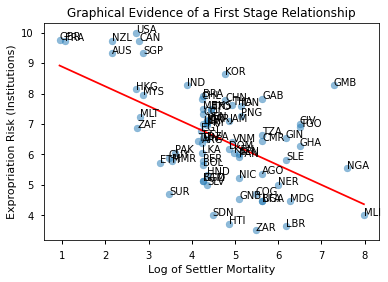

In [30]:
# add numpy so we can get a linear prediction to add to plot
import numpy as np 

# Dropping NA's is required to use numpy's polyfit
df_plot = data.dropna(subset=['logem4', 'avexpr'])
labels = df_plot['shortnam']

fig, ax = plt.subplots()

ax.scatter(df_plot['logem4'], df_plot['avexpr'], alpha=0.5)
# add a linear prediction line on the fly
ax.plot(np.unique(df_plot['logem4']),
         np.poly1d(np.polyfit(df_plot['logem4'], df_plot['avexpr'], 1))(np.unique(df_plot['logem4'])),
         color='red')
# add labels to points
for i, label in enumerate(labels):
    plt.annotate(label, (df_plot['logem4'].iloc[i], df_plot['avexpr'].iloc[i]))
ax.set_xlabel('Log of Settler Mortality')
ax.set_ylabel('Expropriation Risk (Institutions)')
ax.set_title('Graphical Evidence of a First Stage Relationship')


Let's estimate the first stage relationship for the univariate regression model.
To do this and get results similar to AJR we will need to work on a subset of the data where `baseco == 1`, essentially where there are complete data on observations.

In [31]:
data = data.query('baseco ==1')

first_state_reg = smf.ols('avexpr ~ logem4', 
                          data=data)

In [32]:
print(first_state_reg.fit(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     16.32
Date:                Mon, 13 Sep 2021   Prob (F-statistic):           0.000150
Time:                        12:26:10   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3414      0.704     13.264      0.0

So the first stage seems OK with a t-state > 3 (approx F > 10). 

Let's do an IV2SLS estimation.
`statsmodels` does not have the functionality to do IV regression, so we'll need a new package -- `linearmodels`.
We'll only borrow the `IV2SLS` function from the `iv` module:

In [33]:
from linearmodels.iv import IV2SLS

In [34]:
iv_regression = IV2SLS.from_formula('logpgp95 ~ 1 + [avexpr ~ logem4]', 
                                      data=data).fit()

/home/lachlan/anaconda3/lib/python3.7/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


Somewhat differently from `statsmodels`, the `summary` which prints out the STATA-esque regression output is an **attribute** of the fitted model:

In [35]:
iv_regression.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    28.754
Date:                Mon, Sep 13 2021   P-value (F-stat)                0.0000
Time:                        12:26:20   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.9097     1.1740     1.6267     0.1038     -0.3912      4.2106
avexpr         0.9443     0.1761     5.3623     0.0000      0.5991      1.2894
==============================================================================

Endogenous: avexpr
Instruments: logem4
Robust Covariance (Heteroskedastic)
Debiased: False
"""

Unfortunately there is no way to currently get the outputs from a regression estimated via `linearmodels` into a regression table!

### Final Challenge

1. Estimate the IV model for the regression that includes 'asia', 'africa' and 'other' as exogenous explanatory variables
2. Use a robust Hausman test to conduct a formal test for endogeneity. Was the IV strategy appropriate based on this test result?